In [7]:
from map_generator import MapGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
from Planners.abc.abc_problem import ABCProblem
from Planners.pso.pso_problem import PSOProblem
from Planners.gwo.gwo_problem import GWOProblem
#from Planners.a_star.a_star import AStarPlanner
from Planners.util.planner_base import PlannerBase
from Planners.helper import linear_interpolation
from IPython.display import display, clear_output

In [8]:
class AStarPlanner:
    class Node:
        def __init__(self, x_pos, y_pos, goal_node):
            self.x_pos, self.y_pos = x_pos, y_pos
            if goal_node is None:
                goal_node = self
            self.goal_node = goal_node
            self.parent = None
            self.distance = 0
            goal_distance = (x_pos - goal_node.x_pos) ** 2
            goal_distance += (y_pos - goal_node.y_pos) ** 2
            goal_distance = goal_distance ** 0.5
            self.goal_distance = goal_distance
            self.cost = goal_distance
        
        def set_parent(self, parent):
            self.parent = parent
            if self.x_pos == parent.x_pos or self.y_pos == parent.y_pos:
                step_length = 1
            else:
                step_length = 2 ** 0.5
            self.distance = parent.distance + step_length
            self.cost = self.distance + self.goal_distance
        
        def is_goal(self):
            return self.x_pos == self.goal_node.x_pos and self.y_pos == self.goal_node.y_pos

    def __init__(self, curr_map):
        self.map = curr_map
        self.y_min, self.x_min = 0, 0
        self.y_max, self.x_max = curr_map.shape
        self.visited = np.zeros(curr_map.shape, dtype=bool)
    
    def verifyNode(self, node):
        if node.x_pos < self.x_min:
            return False
        if node.x_pos >= self.x_max:
            return False
        if node.y_pos < self.y_min:
            return False
        if node.y_pos >= self.y_max:
            return False
        if self.map[node.y_pos, node.x_pos] == 0:
            return False
        return True
    
    def get_id(self, node):
        return node.y_pos * self.x_max + node.x_pos
    
    def get_neighbours(self, curr_node, goal_node):
        neighbour_nodes = list()
        for x_move in [-1, 0, 1]:
            for y_move in [-1, 0, 1]:
                if x_move == 0 and y_move == 0:
                    continue
                new_node = self.Node(curr_node.x_pos+x_move, curr_node.y_pos+y_move, goal_node)
                new_node.set_parent(curr_node)
                if self.verifyNode(new_node):
                    neighbour_nodes.append(new_node)
        return neighbour_nodes
    
    def get_path(self, start, end):
        goal_node = self.Node(end[0], end[1], None)
        start_node = self.Node(start[0], start[1], goal_node)
        goal_found = False
        
        if not self.verifyNode(start_node) or not self.verifyNode(goal_node):
            return -1
        
        curr_node = start_node
        frontier = dict()
        for node in self.get_neighbours(curr_node, goal_node):
            node_id = self.get_id(node)
            frontier[node_id] = node
        
        while len(frontier):
            curr_node_key = min(frontier, key=lambda node_id: frontier[node_id].cost)
            curr_node = frontier[curr_node_key]
            
            if curr_node.is_goal():
                goal_node.set_parent(curr_node.parent)
                goal_found = True
                break
            
            del frontier[curr_node_key]
            self.visited[curr_node.y_pos, curr_node.x_pos] = True
            
            for node in self.get_neighbours(curr_node, goal_node):
                node_id = self.get_id(node)
                if self.visited[node.y_pos, node.x_pos]:
                    continue
                if node_id not in frontier:
                    frontier[node_id] = node
                else:
                    if frontier[node_id].cost > node.cost:
                        frontier[node_id] = node
        
        if not goal_found:
            print('Path to goal does not exists')
            return np.array([])
        
        path_points = list()
        curr_node = goal_node
        while curr_node.x_pos != start_node.x_pos or curr_node.y_pos !=start_node.y_pos:
            path_points.append([curr_node.x_pos, curr_node.y_pos])
            curr_node = curr_node.parent
        path_points.append([start_node.x_pos, start_node.y_pos])  # add start point
        
        return np.array(path_points)

In [9]:
def get_path_cost(curr_map, path):
    length = 0
    violations = 0
    violation_cost = 0
    prev_x, prev_y = path[0]
    prev_cost = curr_map[prev_y, prev_x]
    root_2 = 2 ** 0.5
    for curr_x, curr_y in path[1:]:
        if curr_x == prev_x or curr_y == prev_y:
            length += 1
        else:
            length += root_2
        curr_cost = curr_map[curr_y, curr_x]
        if curr_cost == 0:
            violation_cost += 1
            if curr_cost != prev_cost:
                violations += 1
        prev_cost = curr_cost
    return length, violations, violation_cost

In [20]:
def get_iteration_callback(curr_map, start, end, planner_name, map_name, run):
    save_dir = os.path.join('results', 'final path')
    save_dir = os.path.join(save_dir, planner_name)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_dir = os.path.join(save_dir, map_name)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_dir = os.path.join(save_dir, 'run_%d'%run)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    def iteration_callback(itr, particle):
        points = particle.reshape(-1, 2)
        points = (points * (np.array(curr_map.shape[::-1]) - 1)).astype(np.int32)
        path = linear_interpolation(start, end, points)
        fig = plt.figure()
        plt.imshow(curr_map, cmap='gray')
        plt.plot(path[:, 0], path[:, 1], label='path')
        plt.scatter([start[0]], [start[1]], label='start')
        plt.scatter([end[0]], [end[1]], label='goal')
        plt.legend(loc='upper right')
        plt.close()
        fig_addr = os.path.join(save_dir, 'iteration_%02d.jpg'%(itr+1))
        fig.savefig(fig_addr)
        print('Saved to:', fig_addr)
    return iteration_callback

def save_final_map(curr_map, start, end, path, planner_name, map_name, run):
    save_dir = os.path.join('results', 'final path')
    save_dir = os.path.join(save_dir, planner_name)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_dir = os.path.join(save_dir, map_name)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_dir = os.path.join(save_dir, 'run_%d'%run)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    fig = plt.figure()
    plt.imshow(curr_map, cmap='gray')
    plt.plot(path[:, 0], path[:, 1], label='path')
    plt.scatter([start[0]], [start[1]], label='start')
    plt.scatter([end[0]], [end[1]], label='goal')
    plt.legend(loc='upper right')
    plt.close()
    fig_addr = os.path.join(save_dir, 'final_map.jpg')
    fig.savefig(fig_addr)
    print('Saved to:', fig_addr)

In [21]:
planner_params = {
    'AStar Planner': {
        'optimizer_params': {}
    },
    'ABC Optimizer': {
        'optimizer': ABCProblem,
        'optimizer_params': {
            'iteration_number': 20,
            'bees': 10,
            'high_step_prob': 0.3
        },
        'cost_func_wt': (2, 1)
    },
    'GWO Optimizer': {
        'optimizer': GWOProblem,
        'optimizer_params': {
            'iteration_number': 20,
            'wolves': 20
        },
        'cost_func_wt': (2, 1)
    },
    'PSO Optimizer': {
        'optimizer': PSOProblem,
        'optimizer_params': {
            'iteration_number': 20,
            'particles': 20,
            'weight': 0.5,
            'c_1': 1.5,
            'c_2': 1.5
        },
        'cost_func_wt': (2, 1)
    }
}

In [22]:
map_details = {
    'map1': {
        'file_name': 'custom_map_2_params.yaml',
        'start': [100, 400],
        'end': [400, 100],
        'points': 1
    },
    'map2': {
        'file_name': 'custom_map_4_params.yaml',
        'start': [50, 250],
        'end': [250, 250],
        'points': 2
    },
    'map3': {
        'file_name': 'custom_map_3_params.yaml',
        'start': [50, 450],
        'end': [300, 100],
        'points': 2
    },
    'map4': {
        'file_name': 'custom_map_1_params.yaml',
        'start': [600, 800],
        'end': [1700, 500],
        'points': 3
    },
    'map5': {
        'file_name': 'map_012_params.yaml',
        'start': [250, 1750],
        'end': [1100, 200],
        'points': 4
    }
}

In [26]:
store_dir = os.path.join('results', 'final_path')
total_runs = 5

map1-AStar Planner-1
Saved to: results\final path\AStar Planner\map1\run_1\final_map.jpg


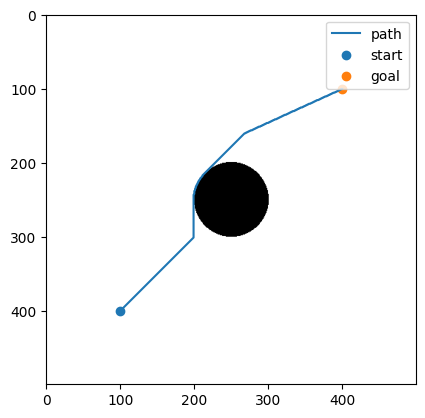

map1-ABC Optimizer-1
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map1\run_1\it

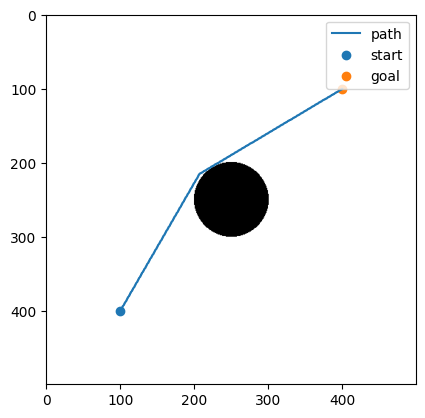

map1-ABC Optimizer-2
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map1\run_2\it

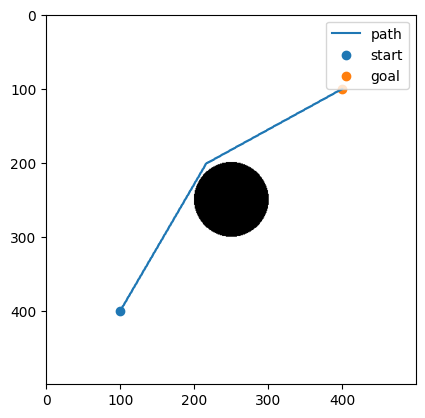

map1-ABC Optimizer-3
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map1\run_3\it

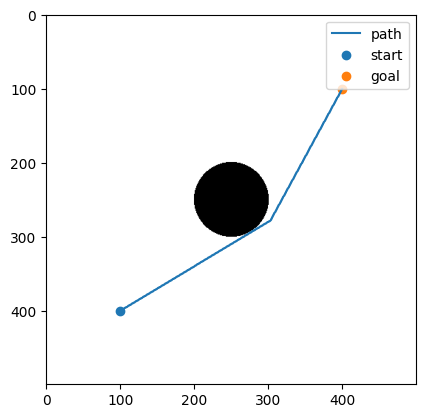

map1-ABC Optimizer-4
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map1\run_4\it

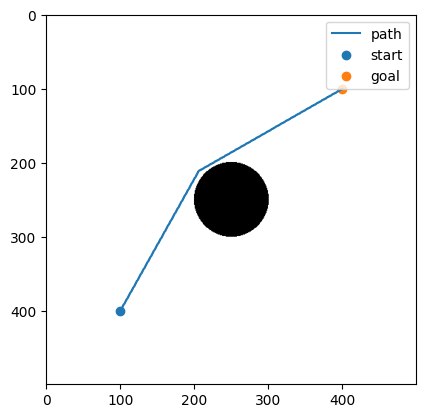

map1-ABC Optimizer-5
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map1\run_5\it

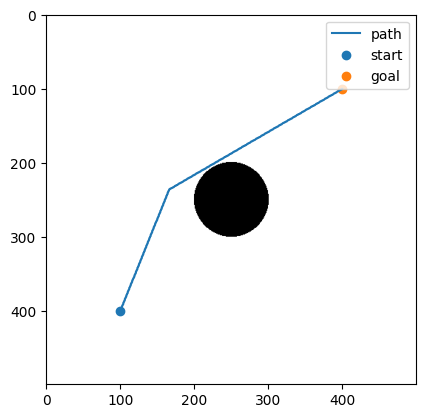

map1-GWO Optimizer-1
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map1\run_1\it

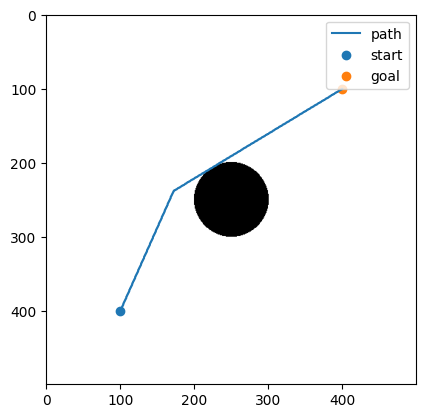

map1-GWO Optimizer-2
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map1\run_2\it

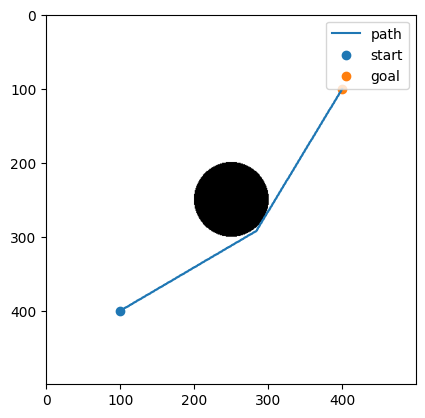

map1-GWO Optimizer-3
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map1\run_3\it

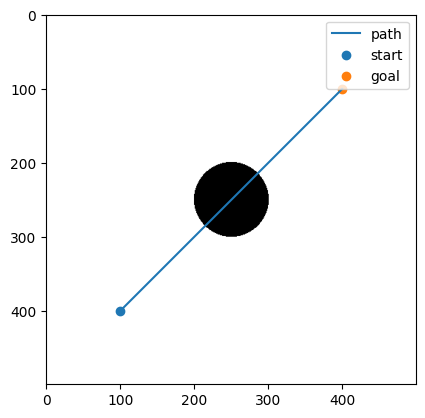

map1-GWO Optimizer-4
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map1\run_4\it

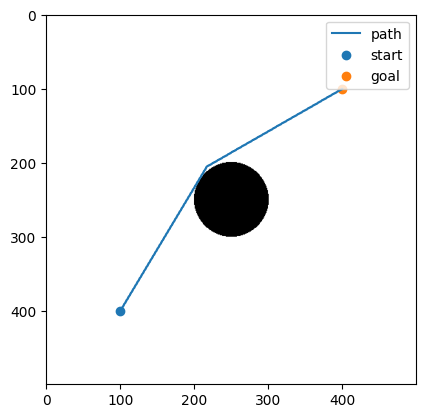

map1-GWO Optimizer-5
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map1\run_5\it

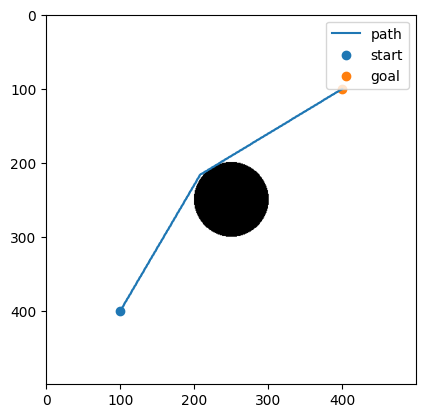

map1-PSO Optimizer-1
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map1\run_1\it

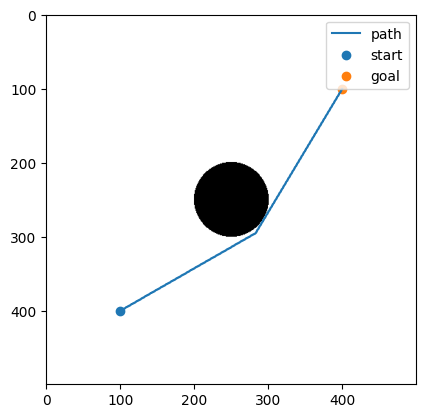

map1-PSO Optimizer-2
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map1\run_2\it

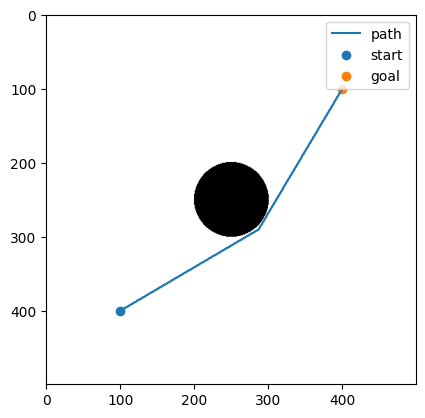

map1-PSO Optimizer-3
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map1\run_3\it

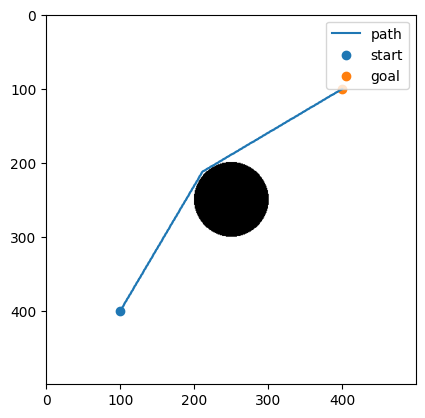

map1-PSO Optimizer-4
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map1\run_4\it

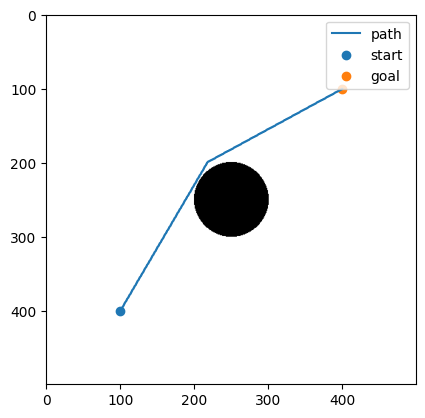

map1-PSO Optimizer-5
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map1\run_5\it

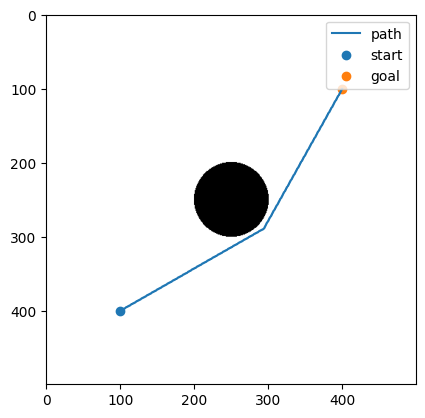

map2-AStar Planner-1
Saved to: results\final path\AStar Planner\map2\run_1\final_map.jpg


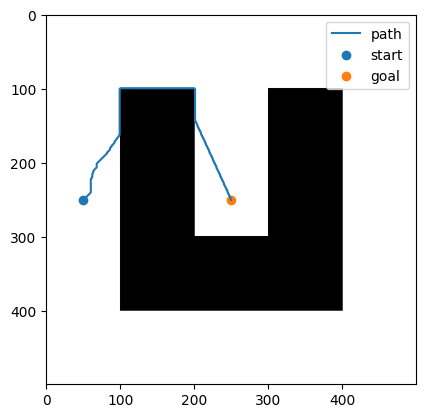

map2-ABC Optimizer-1
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map2\run_1\it

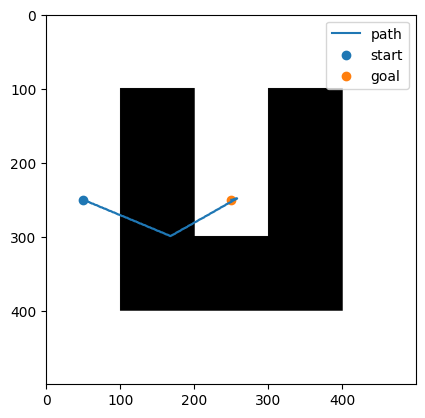

map2-ABC Optimizer-2
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map2\run_2\it

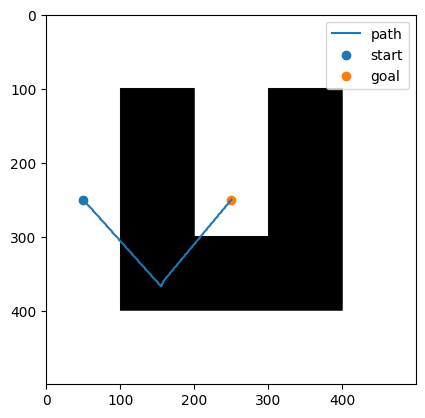

map2-ABC Optimizer-3
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map2\run_3\it

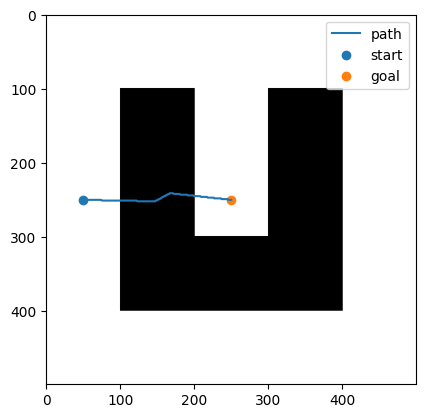

map2-ABC Optimizer-4
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map2\run_4\it

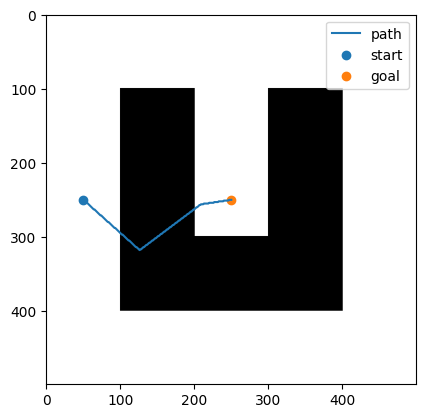

map2-ABC Optimizer-5
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map2\run_5\it

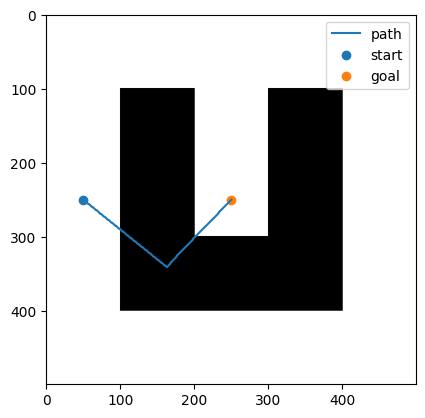

map2-GWO Optimizer-1
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map2\run_1\it

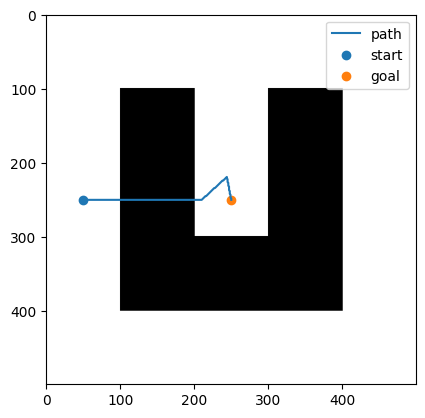

map2-GWO Optimizer-2
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map2\run_2\it

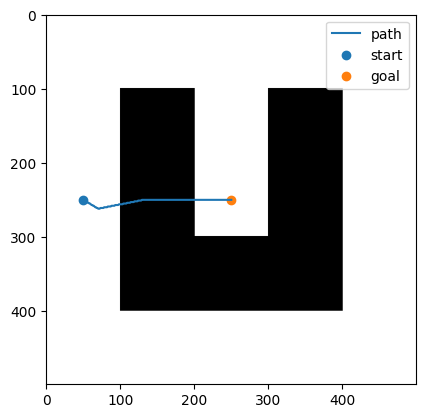

map2-GWO Optimizer-3
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map2\run_3\it

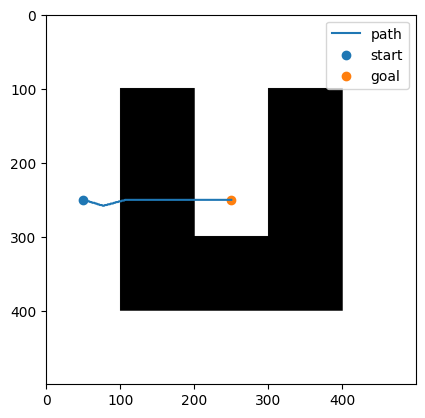

map2-GWO Optimizer-4
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map2\run_4\it

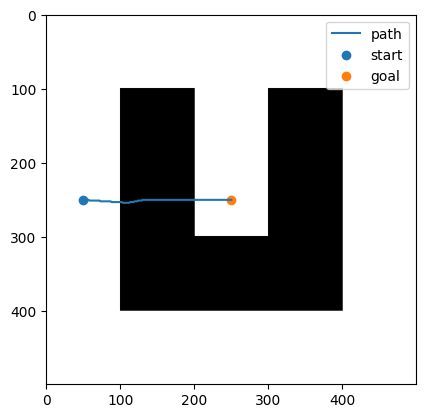

map2-GWO Optimizer-5
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map2\run_5\it

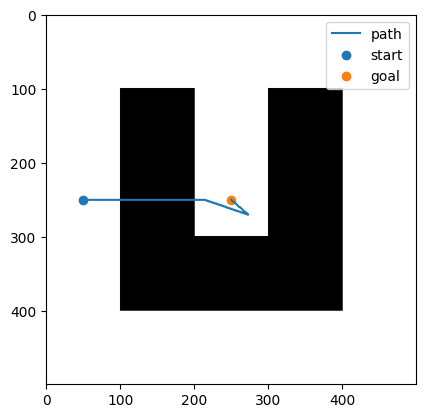

map2-PSO Optimizer-1
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map2\run_1\it

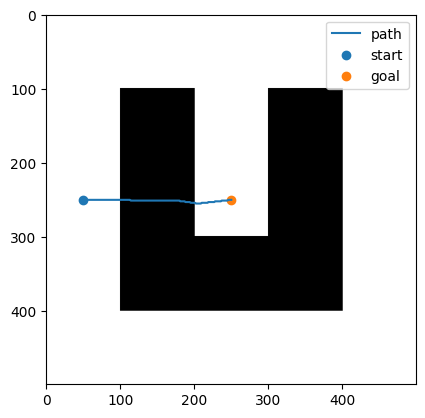

map2-PSO Optimizer-2
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map2\run_2\it

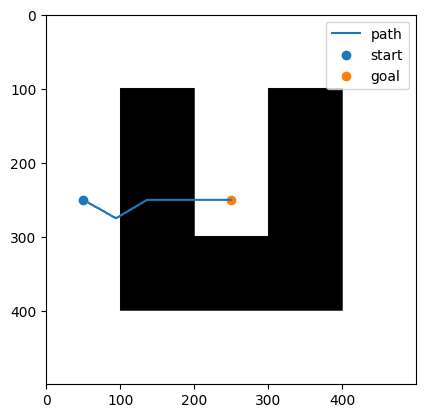

map2-PSO Optimizer-3
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map2\run_3\it

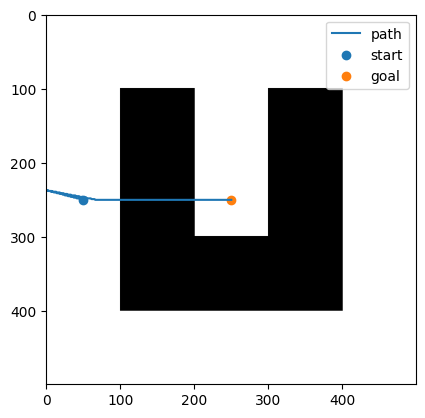

map2-PSO Optimizer-4
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map2\run_4\it

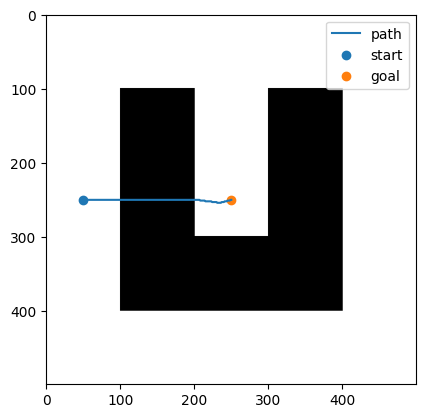

map2-PSO Optimizer-5
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map2\run_5\it

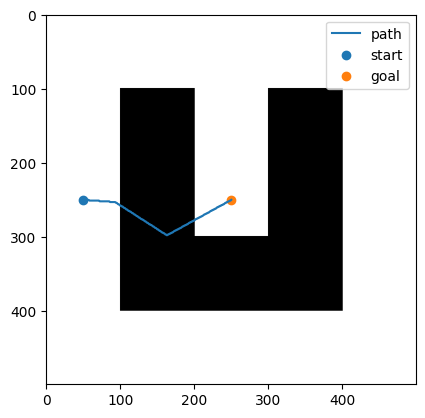

map3-AStar Planner-1
Saved to: results\final path\AStar Planner\map3\run_1\final_map.jpg


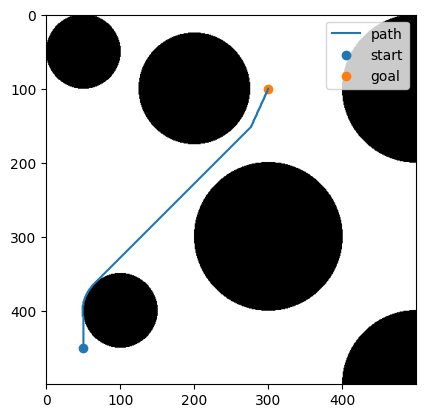

map3-ABC Optimizer-1
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map3\run_1\it

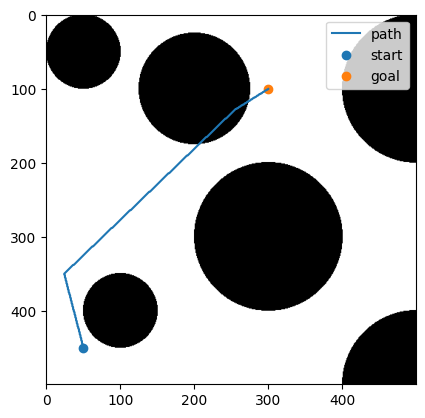

map3-ABC Optimizer-2
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map3\run_2\it

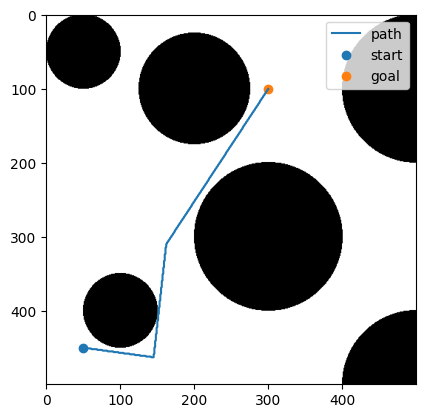

map3-ABC Optimizer-3
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map3\run_3\it

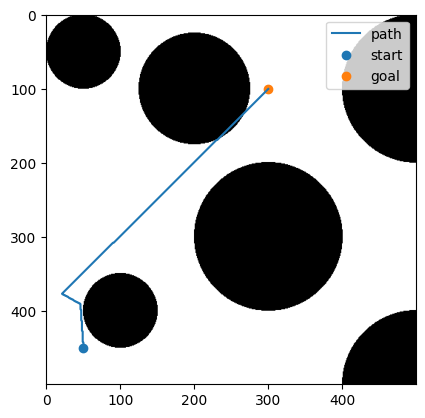

map3-ABC Optimizer-4
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map3\run_4\it

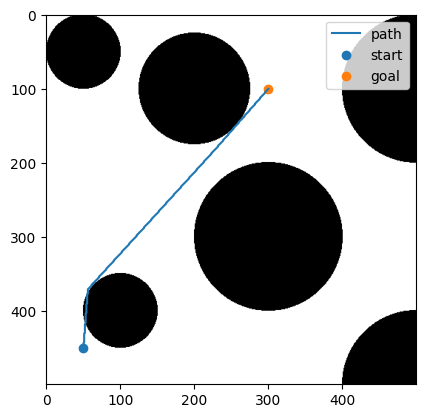

map3-ABC Optimizer-5
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map3\run_5\it

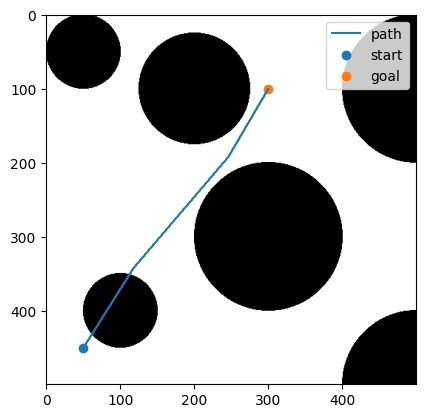

map3-GWO Optimizer-1
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map3\run_1\it

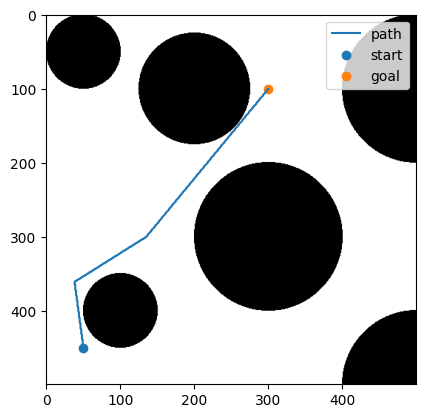

map3-GWO Optimizer-2
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map3\run_2\it

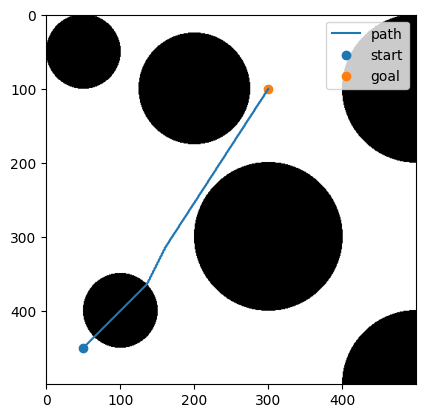

map3-GWO Optimizer-3
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map3\run_3\it

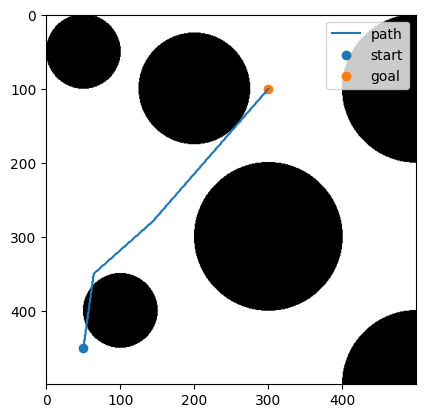

map3-GWO Optimizer-4
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map3\run_4\it

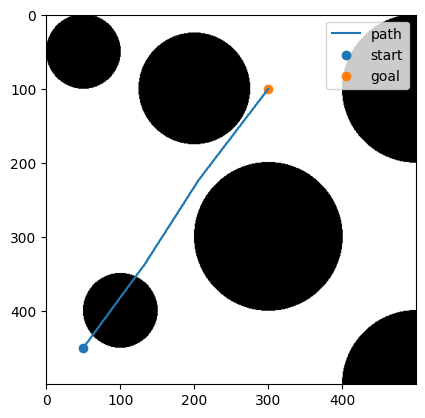

map3-GWO Optimizer-5
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map3\run_5\it

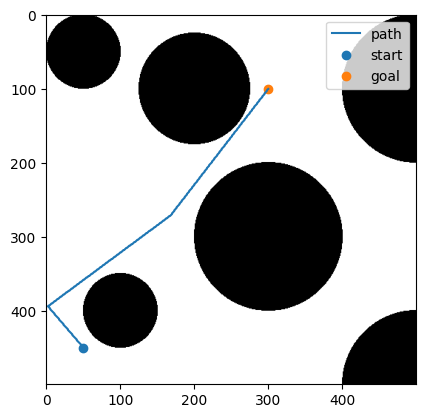

map3-PSO Optimizer-1
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map3\run_1\it

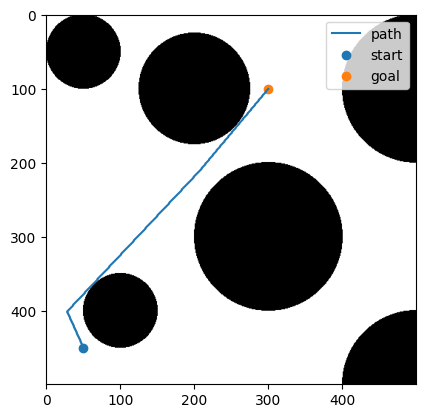

map3-PSO Optimizer-2
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map3\run_2\it

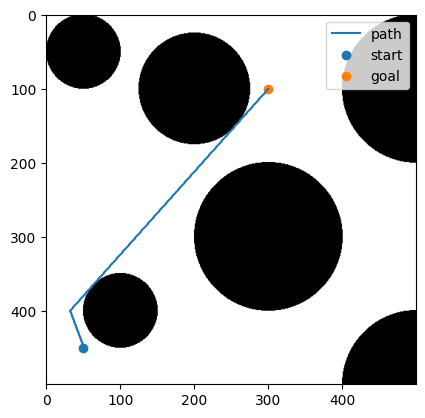

map3-PSO Optimizer-3
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map3\run_3\it

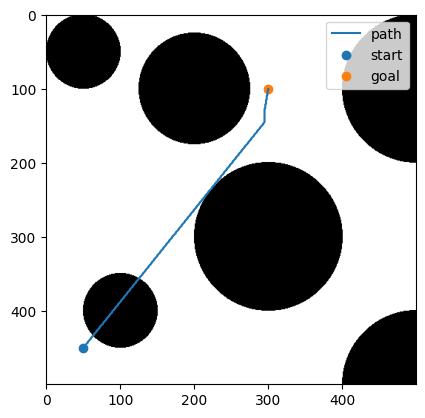

map3-PSO Optimizer-4
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map3\run_4\it

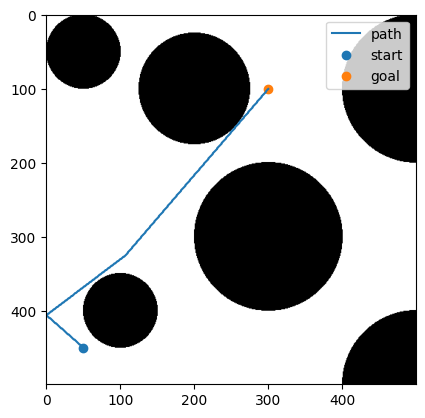

map3-PSO Optimizer-5
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map3\run_5\it

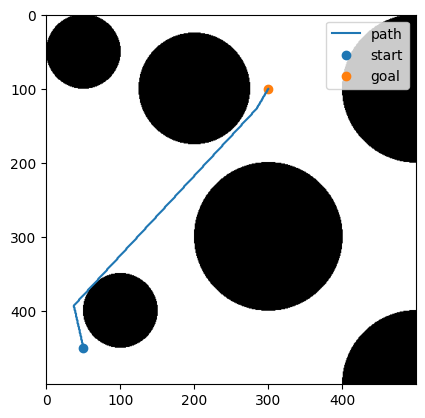

map4-AStar Planner-1
Saved to: results\final path\AStar Planner\map4\run_1\final_map.jpg


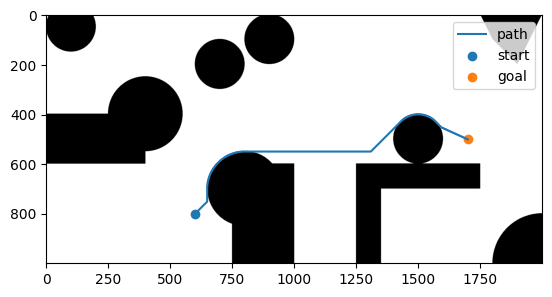

map4-ABC Optimizer-1
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map4\run_1\it

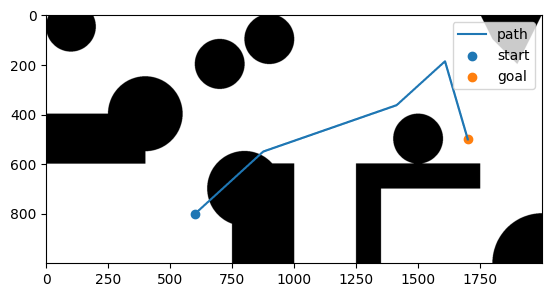

map4-ABC Optimizer-2
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map4\run_2\it

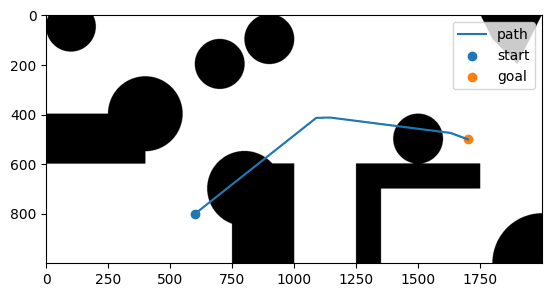

map4-ABC Optimizer-3
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map4\run_3\it

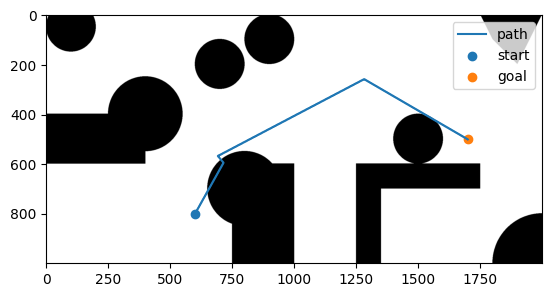

map4-ABC Optimizer-4
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map4\run_4\it

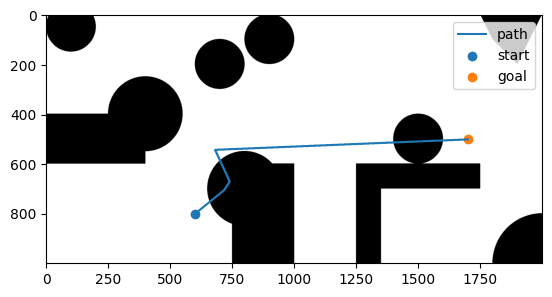

map4-ABC Optimizer-5
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map4\run_5\it

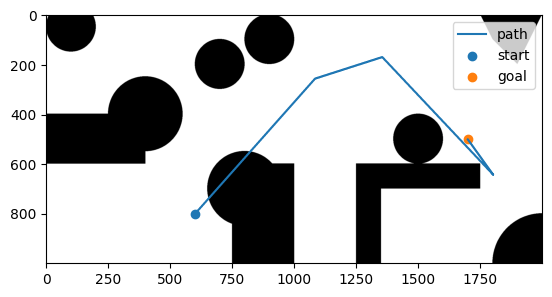

map4-GWO Optimizer-1
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map4\run_1\it

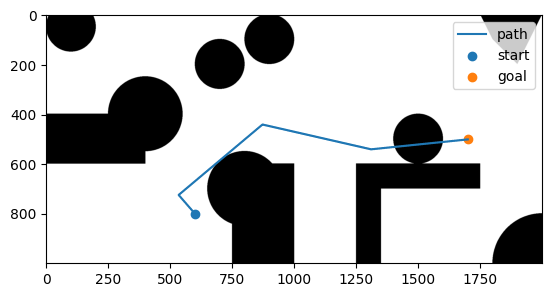

map4-GWO Optimizer-2
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map4\run_2\it

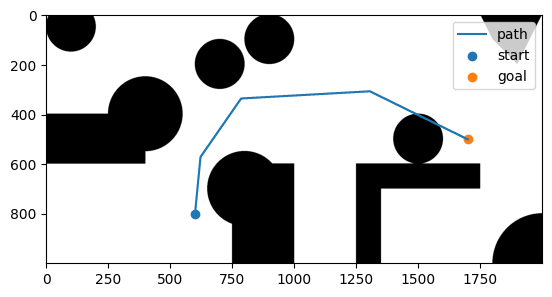

map4-GWO Optimizer-3
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map4\run_3\it

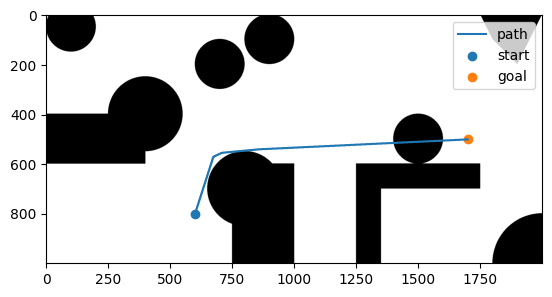

map4-GWO Optimizer-4
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map4\run_4\it

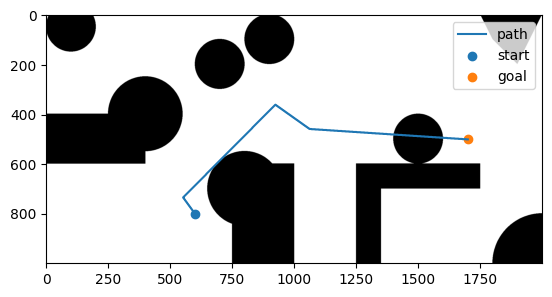

map4-GWO Optimizer-5
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map4\run_5\it

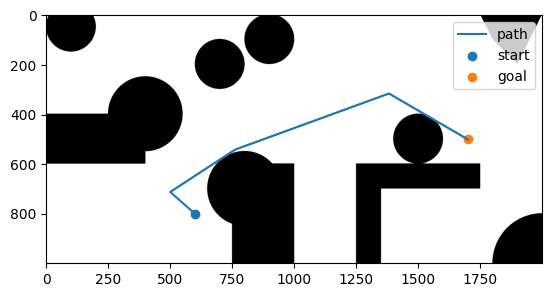

map4-PSO Optimizer-1
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map4\run_1\it

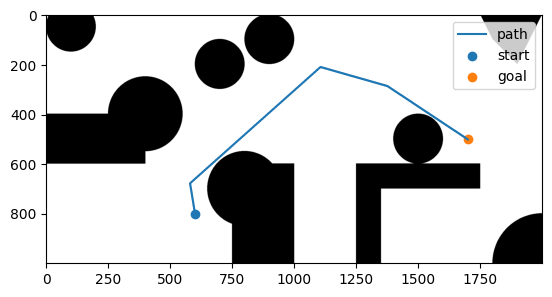

map4-PSO Optimizer-2
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map4\run_2\it

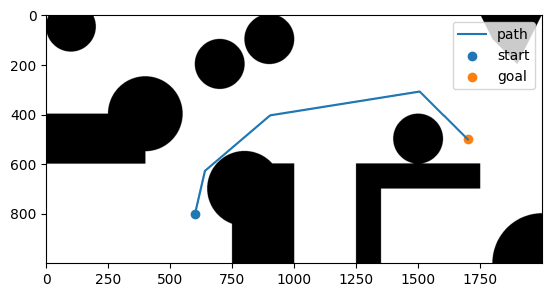

map4-PSO Optimizer-3
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map4\run_3\it

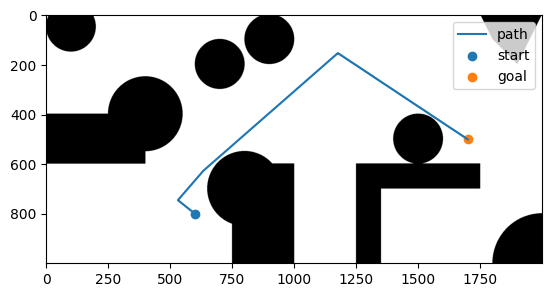

map4-PSO Optimizer-4
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map4\run_4\it

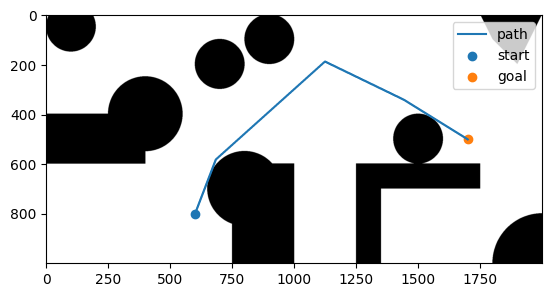

map4-PSO Optimizer-5
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map4\run_5\it

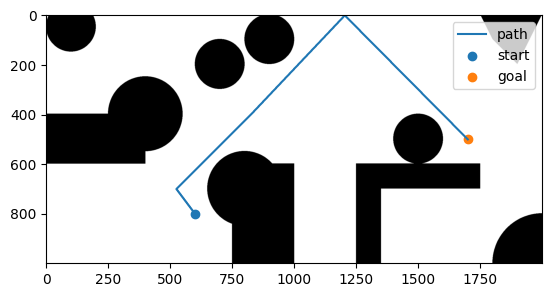

map5-AStar Planner-1
Saved to: results\final path\AStar Planner\map5\run_1\final_map.jpg


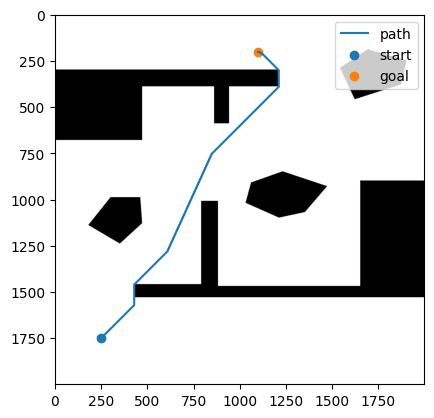

map5-ABC Optimizer-1
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map5\run_1\it

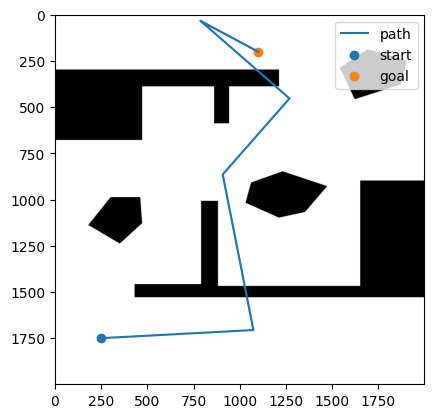

map5-ABC Optimizer-2
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map5\run_2\it

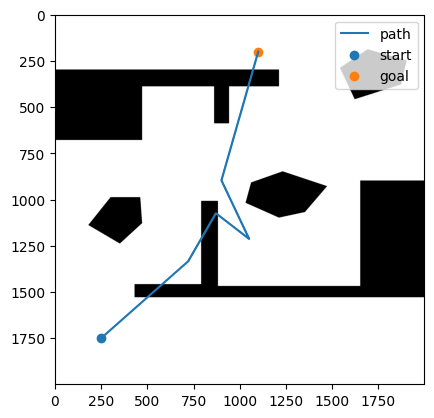

map5-ABC Optimizer-3
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map5\run_3\it

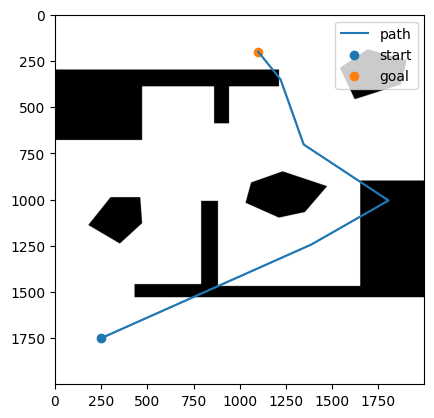

map5-ABC Optimizer-4
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map5\run_4\it

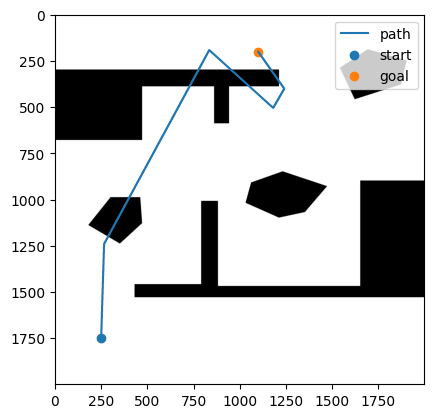

map5-ABC Optimizer-5
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_01.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_02.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_03.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_04.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_05.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_06.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_07.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_08.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_09.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_10.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_11.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_12.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\iteration_13.jpg
Saved to: results\final path\ABC Optimizer\map5\run_5\it

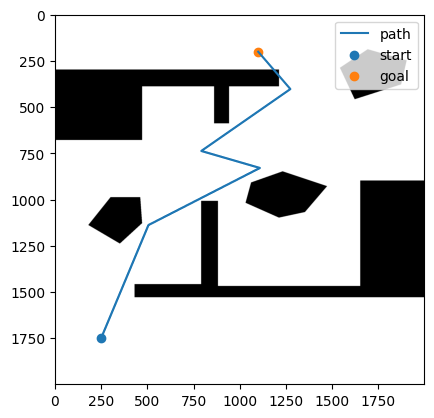

map5-GWO Optimizer-1
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map5\run_1\it

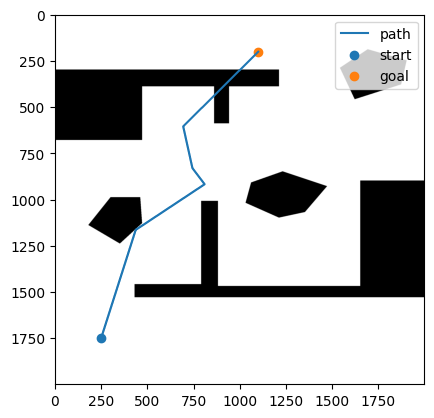

map5-GWO Optimizer-2
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map5\run_2\it

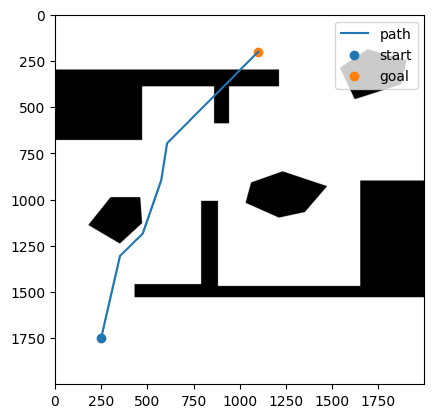

map5-GWO Optimizer-3
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map5\run_3\it

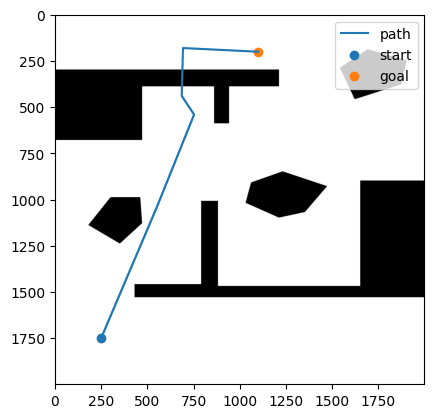

map5-GWO Optimizer-4
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map5\run_4\it

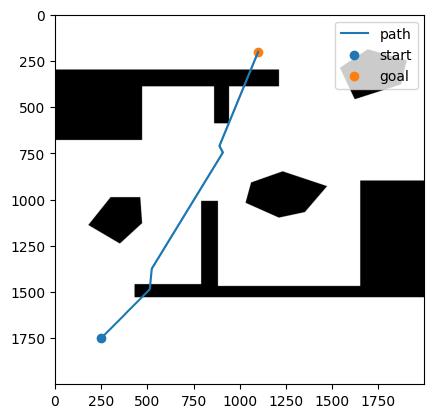

map5-GWO Optimizer-5
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_01.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_02.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_03.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_04.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_05.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_06.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_07.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_08.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_09.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_10.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_11.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_12.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\iteration_13.jpg
Saved to: results\final path\GWO Optimizer\map5\run_5\it

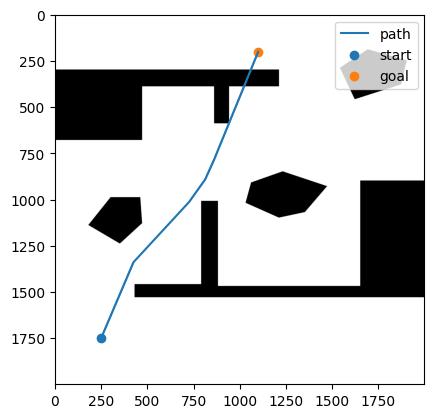

map5-PSO Optimizer-1
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map5\run_1\it

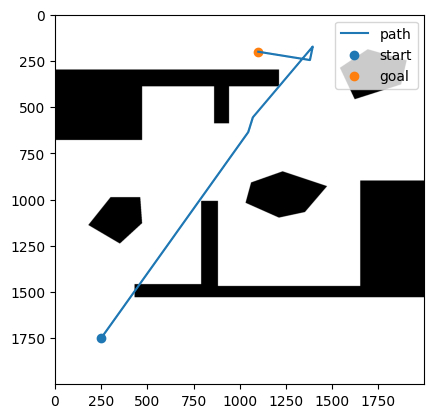

map5-PSO Optimizer-2
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map5\run_2\it

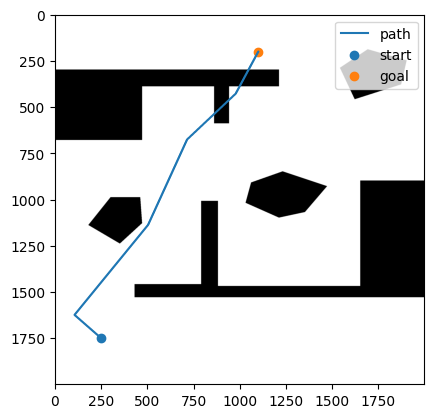

map5-PSO Optimizer-3
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map5\run_3\it

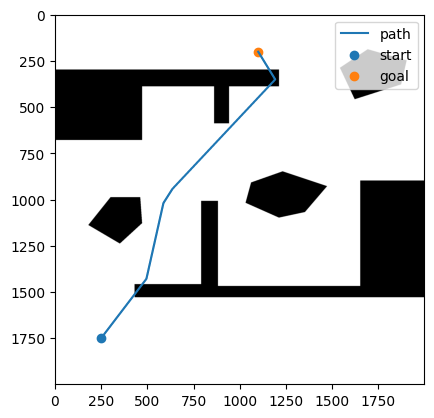

map5-PSO Optimizer-4
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map5\run_4\it

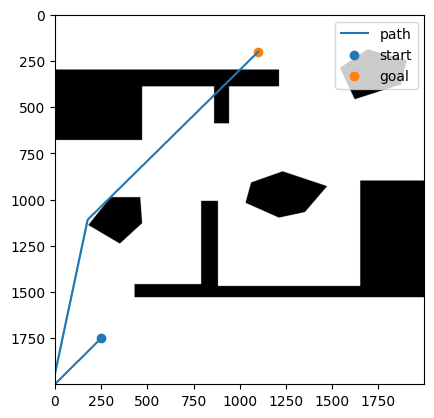

map5-PSO Optimizer-5
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_01.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_02.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_03.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_04.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_05.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_06.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_07.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_08.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_09.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_10.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_11.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_12.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\iteration_13.jpg
Saved to: results\final path\PSO Optimizer\map5\run_5\it

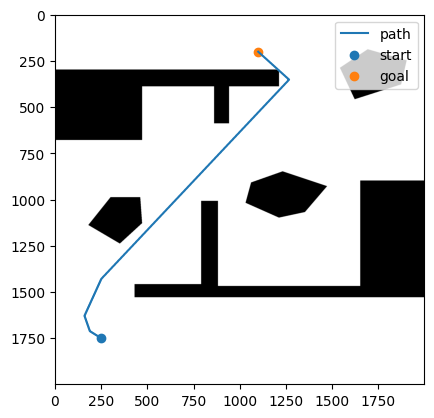

In [27]:
for map_name in map_details.keys():
    curr_details = map_details[map_name]
    
    file_name = curr_details['file_name']
    map_file_name = file_name.split('.')[0]
    map_gen = MapGenerator(os.path.join('map_params', file_name))
    curr_map = map_gen.map.get_map()
    
    start = np.array(curr_details['start']).astype(np.int32)
    end = np.array(curr_details['end']).astype(np.int32)
    
    for planner_name in planner_params.keys():
        curr_params = planner_params[planner_name]
        curr_params['map'] = curr_map
        
        opt_params = curr_params['optimizer_params']
        opt_params['points'] = curr_details['points']
        
        for i in range(total_runs):
            run = i + 1
            print(map_name, planner_name, run, sep='-')
            opt_params['iteration_callback'] = get_iteration_callback(curr_map, start, end, planner_name, map_name, run)
            if planner_name == 'AStar Planner':
                planner = AStarPlanner(curr_map)
            else:
                planner = PlannerBase(**curr_params)
            path = planner.get_path(start, end)
            save_final_map(curr_map, start, end, path, planner_name, map_name, run)
            fig = plt.figure()
            plt.imshow(curr_map, cmap='gray')
            plt.plot(path[:, 0], path[:, 1], label='path')
            plt.scatter([start[0]], [start[1]], label='start')
            plt.scatter([end[0]], [end[1]], label='goal')
            plt.legend(loc='upper right')
            plt.show()
            if planner_name == 'AStar Planner':
                break